# Exercício 3: Q-Learning aplicado no Supply Chain

Vamos implementar o ambiente do problema de Supply Chain (Beer Distribution Game) visto na aula 2 e resolvê-los com o algoritmo de Q-Learning.

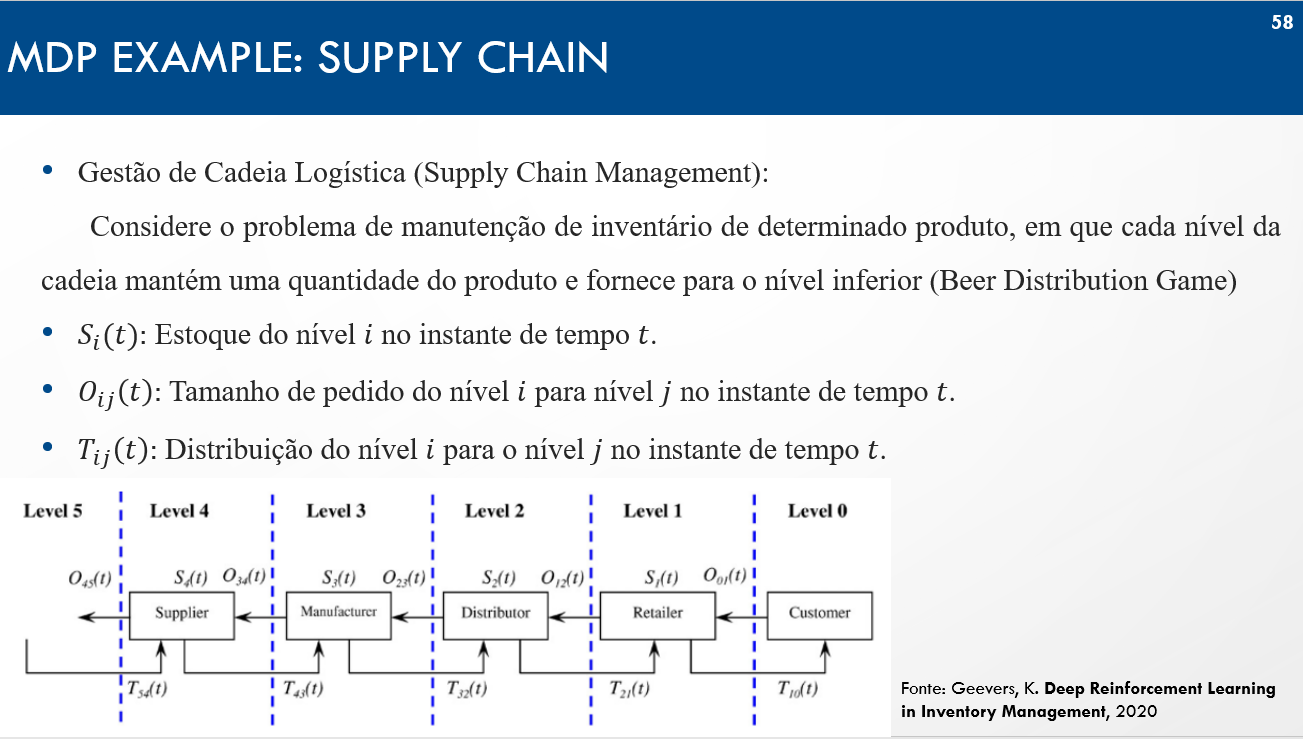

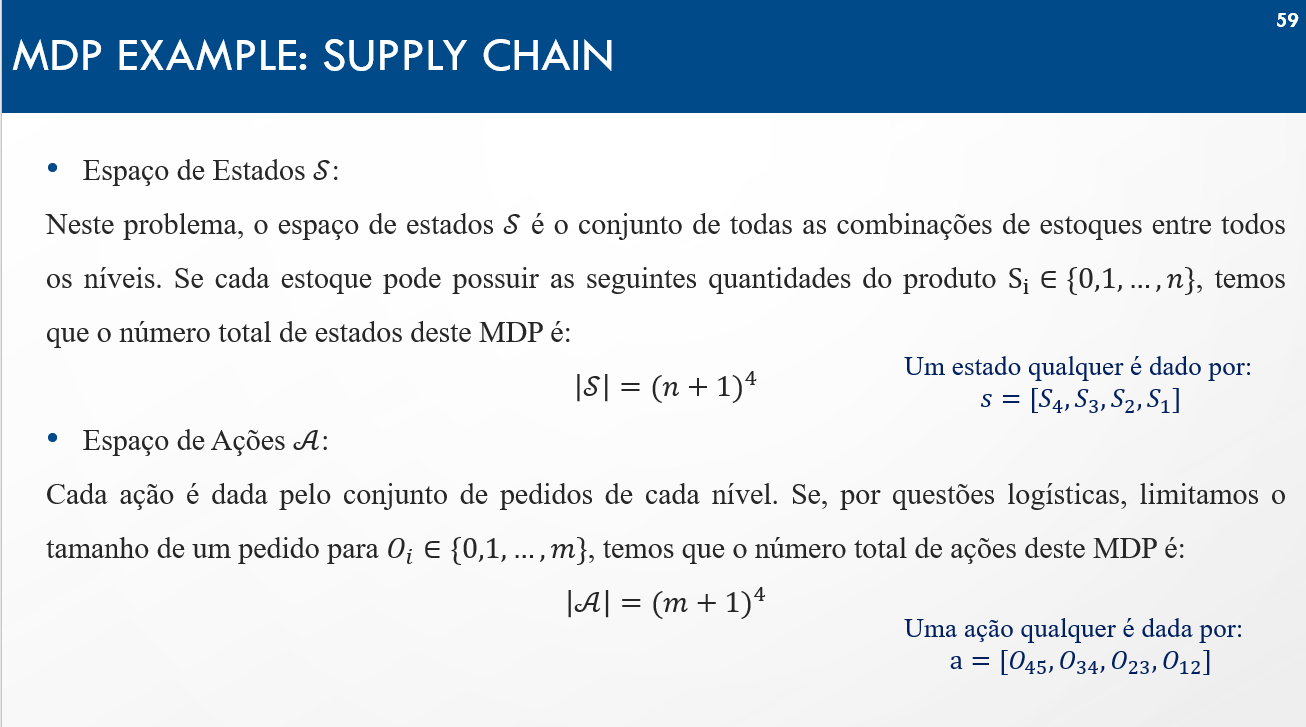

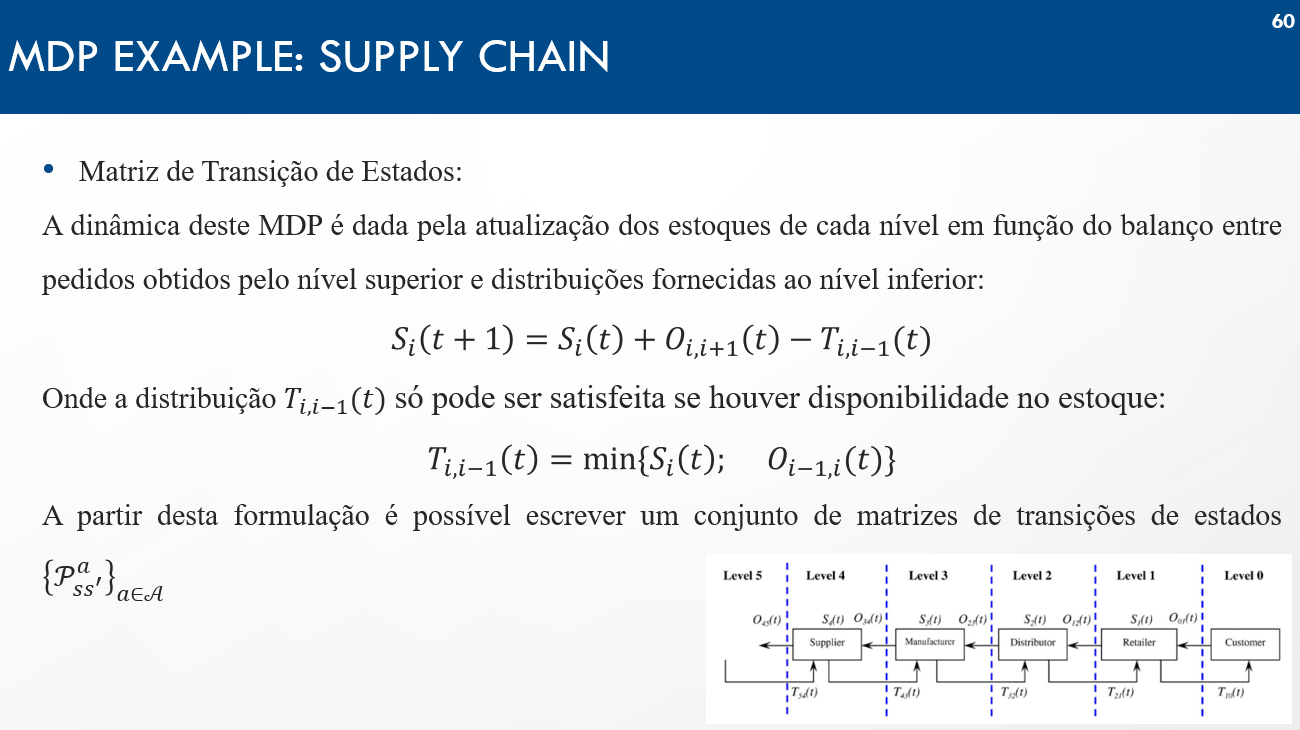

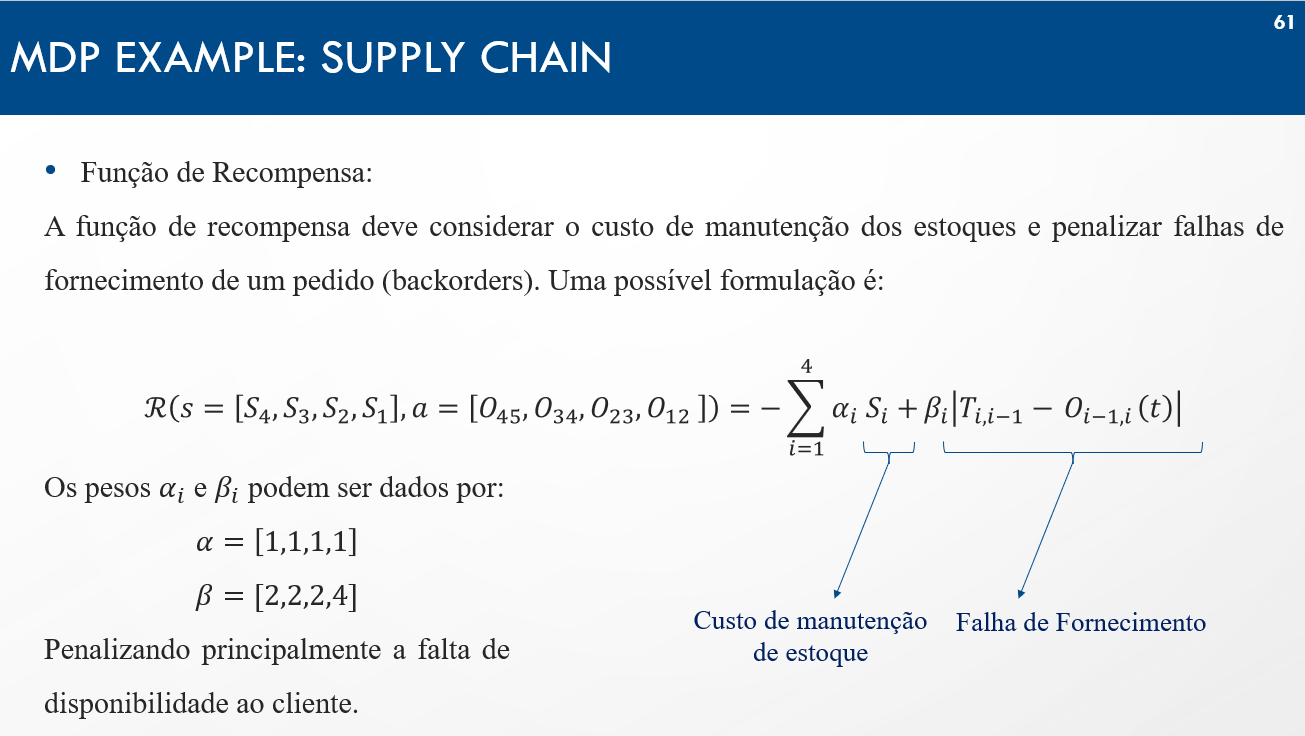

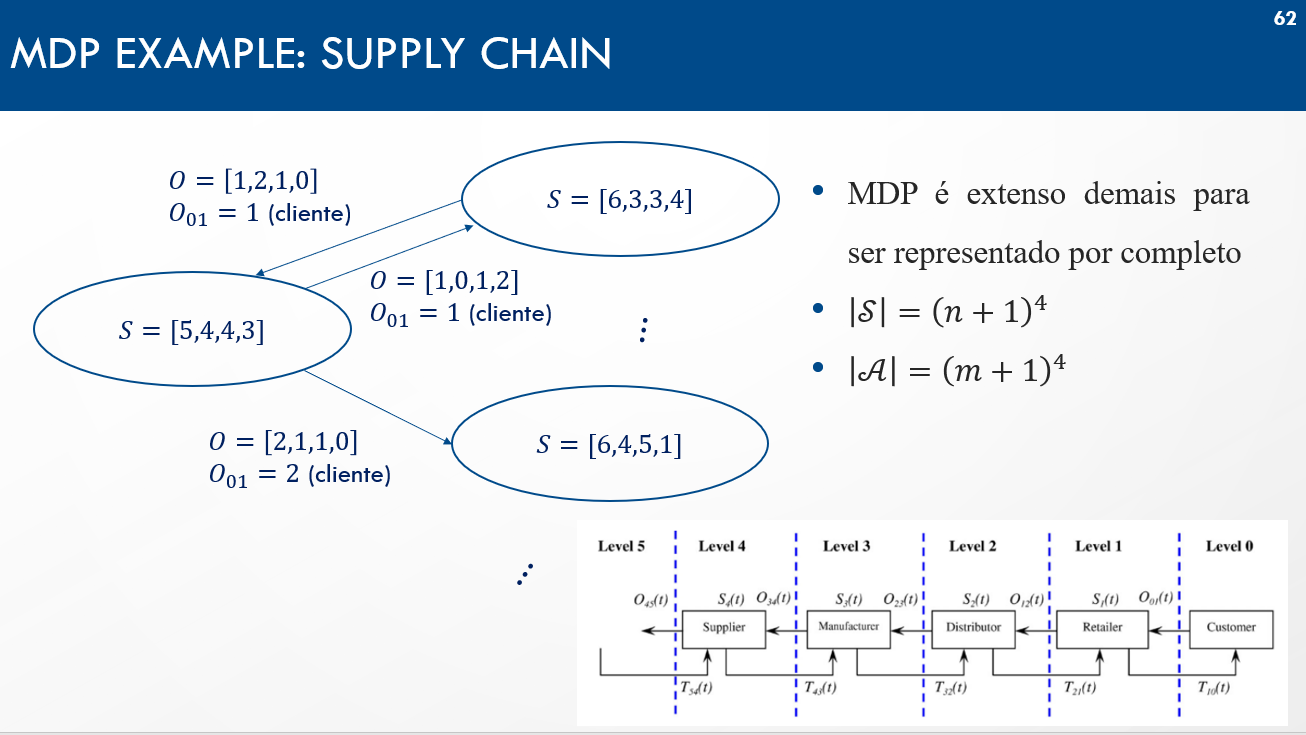

## Tarefas

Tarefa A) Implementar as funções choose_action e learn para a criação da Classe Agent_QLearning

Tarefa B) Implementar o loop de treino

Tarefa C) Implementar as funções choose_action e learn para a criação da Classe Agent_Double_QLearning

## Códigos

### Imports

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
from collections import Counter

plt.style.use('fivethirtyeight')

### Environment Class

In [2]:
class BeerGameEnv:
    def __init__(self,max_inventory, max_order, avg_customer_demand = 2, ALPHA = [1,1,1,1], BETA = [2,2,2,4],MAX_TIMESTEP = 180):

        # Supply Chain Levels
        self.levels = ['Supplier', 'Manufacturer', 'Distributor', 'Retailer']
        self.ALPHA = ALPHA # Inventory Management Cost per product on each level
        self.BETA = BETA # Inventory Lack of Supply Cost per product on each level
        self.avg_customer_demand = avg_customer_demand
        self.MAX_TIMESTEP = MAX_TIMESTEP

        # MDP State Space
        n_levels = len(self.levels)
        inventories = list(range(max_inventory+1))
        aux = [inventories] * n_levels
        state_space = list(itertools.product(*aux))
        self.state_space = [list(e) for e in state_space]

        # MDP Action Space
        orders = list(range(max_order+1))
        aux = [orders] * n_levels
        action_space = list(itertools.product(*aux))
        self.action_space = [list(e) for e in action_space]

        # Initial State
        initial_inventory = int(max_inventory/2)
        self.initial_state = list(initial_inventory*np.ones(len(self.levels)).astype(int))
    
    def show(self):
        fig = plt.figure()
        ax = fig.gca()
        ax.bar(self.levels, self.s)
        ax.set_xlabel('Supply Chain Level')
        ax.set_ylabel('Inventory')
    
    def reset(self, random_init=True):
        self.t = 0
        if not random_init:
            self.s = self.initial_state.copy()
        else:
            self.s = random.choice(self.state_space)

        return self.s
    
    def step(self, a, demand_random):
        # Increment Time-Step
        self.t += 1

        # Customer Demand
        #-------------------------------------------------------
        if demand_random:
          gaussian = np.random.normal(self.avg_customer_demand)
          customer_demand = max([0, int(np.round(gaussian))])
        else:
          customer_demand = self.avg_customer_demand

        # Add Customer demand as last level 'order'
        order = a.copy()
        order.append(customer_demand)
        #-------------------------------------------------------

        # distributions to lower level (from customer to supplier)
        #-----------------------------------------------------------------------
        # Verify if inventory supports order (minimum inventory)
        T = []
        for i in range(len(self.levels)-1, -1, -1):
            distribution = min([self.s[i], order[i+1]])
            T.append(distribution)
        T.reverse()

        # Verify if order causes inventory to exceed maximum (maximum inventory)
        for i in range(len(self.levels)-2, -1, -1):
            if (self.s[i+1] + T[i] - T[i+1] > 9):
                dif = (self.s[i+1] + T[i] - T[i+1]) - 9
                T[i] = T[i] - dif
        #-----------------------------------------------------------------------
        

        # Reward Function
        r = 0
        for i in range(1,len(self.levels)):
            r -= self.ALPHA[i]*self.s[i] + self.BETA[i]*max([0,  order[i+1] - T[i]])


        # Next State
        S_next = self.s.copy()
        S_next[0] = min([S_next[0] + order[0] - T[0],  9])
        for i in range(1,len(self.levels)):
            S_next[i] = min([self.s[i] + T[i-1] - T[i], 9])
        
        # Update Current State
        self.s = S_next.copy()

        # Check end of episode
        done = False
        if (self.t == self.MAX_TIMESTEP):
            done = True
        
        return S_next, r, done



### Funções Auxiliares

In [3]:
# Plot the average rewards of each epoch during training
def plot_avg_rewards(avg_rewards_list, agent_type):
  fig = plt.figure()
  ax = fig.gca()
  ax.plot(avg_rewards_list, lw=1.5)
  fig.suptitle(agent_type + ' on Beer Game Environment', fontsize=16)
  ax.set_xlabel('Epoch', fontsize=14)
  ax.set_ylabel('Average Rewards', fontsize=14)
  plt.show()

# Print the action space of the environment
def print_states_actions(env):
  print('Espaço de Estados ' + str(env.state_space))
  print('|S| = ' + str(len(env.state_space)))
  print('Espaço de Ações: ' + str(env.action_space))
  print('|A| = ' + str(len(env.action_space)))


### Tarefa A) Agente Q-Learning

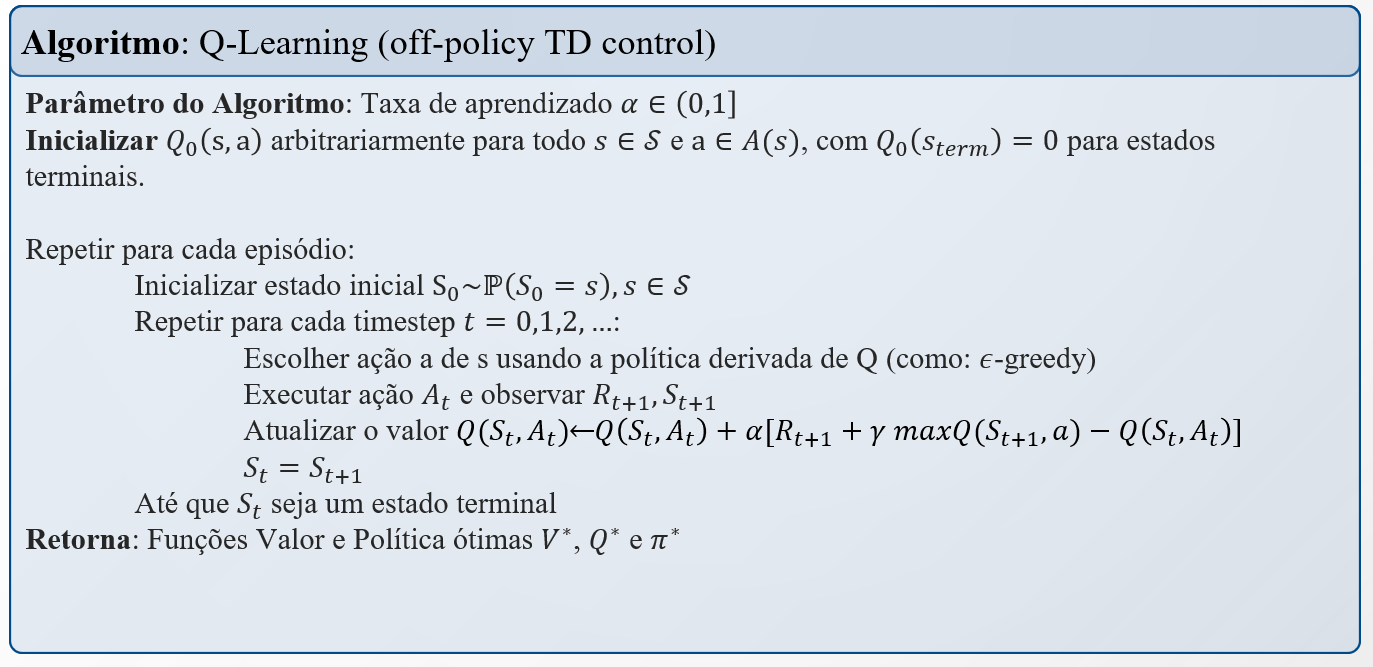

Terminar as funções choose_action e learn dentro da classe Agent

In [54]:
import random

class Agent_QLearning():
    def __init__(self, action_space, epsilon=0.99, alpha=0.9, gamma=0.3):

        # Looks like n is number of valid actions from the souce code
        self.valid_actions = action_space

        # Set parameters of the learning agent
        self.Q = dict()          # Q-table 
        self.epsilon = epsilon   # Random exploration rate
        self.alpha = alpha       # Learning rate
        self.gamma = gamma       # Discount rate- closer to 1 learns well into distant future



    def create_Q_if_new_observation(self, observation):
        """
        Set intial Q values to 0.0 if observation not already in Q table
        """
        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)

    def get_maxQ(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of
        all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        return max(self.Q[observation].values())



    #------------------------------------------------------------------------------
    # COMPLETAR
    #
    # choose_action(self, observation)
    #      Função que escolhe a ação seguindo a política epsilon-Greed
    #
    # INPUT:
    # observation
    #
    # OUTPUT:
    # action
    #------------------------------------------------------------------------------
    def choose_action(self, observation):
        """
        Choose which action to take, based on the observation.
        If observation is seen for the first time, initialize its Q values to 0.0
        """
        self.create_Q_if_new_observation(observation)
        action = None
        # uniformly distributed random number > epsilon happens with probability 1-epsilon
        if random.random() > self.epsilon:
            maxQ = self.get_maxQ( observation )
            for va in self.valid_actions:
                if self.Q[ observation ][ va ] == maxQ:
                    action = va
                    break
        # else choose a random action
        else:
            ai = random.randint( 0, len(self.valid_actions) - 1 )
            action = self.valid_actions[ai]
        return action

    #------------------------------------------------------------------------------
    # COMPLETAR
    # learn(self, observation, action, reward, next_observation)
    #     Função que realiza o update da tabela Q
    #
    # INPUT:
    # observation
    # action
    # reward
    # next_observation
    #
    # OUTPUT:
    #------------------------------------------------------------------------------
    def learn(self, observation, action, reward, next_observation):
        """
        Called after the agent completes an action and receives a reward.
        """
        self.Q[observation][action] = self.Q[observation][action] + self.alpha * \
            ( reward + self.gamma * self.get_maxQ( next_observation ) - self.Q[observation][action] )
        pass

### Tarefa B) Loop De Treino



In [60]:
#------------------------------------------------------------------------------
# loop_treino
#
# INPUT:
# demand_random: Determina se a demanda do costumidos é um valor constante (no caso de False) ou um valor aleatória que depende da distribuição normal (no caso de True)
# avg_customer_demand: valor exato do demanda do consumidor no caso de demand_random = False e valor médio de demanda do consumidor no caso demand_random = True
# max_inventory: Valor máximo de ítens que podem ficar armazenados no inventório em cada level
# max_order: Valor máximo de um pedido
# num_epochs: Número de épocas de treino
#
#
# OUTPUT:
#------------------------------------------------------------------------------

def loop_treino(demand_random = False, avg_customer_demand = 2, max_inventory = 5, max_order = 3, \
                num_episodes = 100000, agent_type = 'Q_Learning'):

    # Criando o enviromenment 
    env = BeerGameEnv(max_inventory = max_inventory, max_order = max_order, avg_customer_demand = avg_customer_demand)
    #print_states_actions(env)

    # Iniciando o agente
    action_strings = []
    for action in env.action_space:
        action_strings.append(" ".join([str(i) for i in action]))

    #iniciando o agente
    if agent_type == 'Q_Learning':
        agent = Agent_QLearning(action_space = action_strings, epsilon=0.99, alpha=0.9, gamma=0.3)
    if agent_type == 'Double_QLearning': 
        agent = Agent_Double_QLearning(action_space = action_strings, epsilon=0.99, alpha=0.9, gamma=0.3)


    # Iniciando as listas 

    avg_rewards_list = []

    for episode in range(num_episodes):
        # ---------------------------------------------------
        # COMPLETAR:
        # Resetar o ambiente. Colocar a flag random_init como True para simular um ambiente que pode começar
        # em qualquer estado e não um estado inicial fixo
        observation = env.reset( random_init=True )
        # ---------------------------------------------------
        is_terminal = False
        sum_rewards = 0
        while is_terminal == False:
            
            # O environment envia as observation no formato de lista. 
            # Como o agente usa a observation como chave do dicionário, precisamos alterá-lo para uma string
            # pois uma lista não pode ser chave 
            observation_string = " ".join([str(i) for i in observation])
            # ---------------------------------------------------
            # COMPLETAR:
            # Utilizar a observation_string para o agent escolher uma ação
            action_string = agent.choose_action( observation_string )
            # ---------------------------------------------------
            # Novamente, o environment recebe as ações no formato de lista, enquanto no agent é uma string
            # Portanto precisamos converter de lista para string
            action = [int(i) for i in action_string.split(" ")]
            # ---------------------------------------------------
            # COMPLETAR:
            # Função step
            # Utilizar a action para o env rodar um step. Lembrar de adicionar a flag
            # demand_random como input      
            next_observation, reward, is_terminal = env.step( action, demand_random=demand_random )
            # ---------------------------------------------------
            # O environment envia as observation no formato de lista. 
            # Como o agente usa a observation como chave do dicionário, precisamos alterá-lo para uma string
            # pois uma lista não pode ser chave 
            next_observation_string =  " ".join([str(i) for i in next_observation])
            # ---------------------------------------------------
            # COMPLETAR:
            # Utilizar a função learn do agente para fazer update da tabela Q . Lembrar de utilizar a
            # observation_string, next_observation_string e action_string   
            agent.learn(observation_string, action_string, reward, next_observation_string)
            # ---------------------------------------------------

            # ---------------------------------------------------
            # COMPLETAR:
            # Atualizar as observações St = St+1
            observation = next_observation
            # ---------------------------------------------------

            sum_rewards += reward

        # Realizando o decay linear dos hiperparâmetros epsilon e alpha
        agent.epsilon -= 0.999/num_episodes
        agent.alpha -= 0.5995/num_episodes

        # lista de avg_rewards para o print
        avg_rewards_list.append(sum_rewards/env.MAX_TIMESTEP)

        # Printar para acompanhar o episódio
        if episode % 5000 == 0:
          print("Episódio: " + str(episode))
    plot_avg_rewards(avg_rewards_list, agent_type)

#### Teste para demanda do consumidor constante 

Episódio: 0
Episódio: 5000
Episódio: 10000
Episódio: 15000
Episódio: 20000
Episódio: 25000
Episódio: 30000
Episódio: 35000
Episódio: 40000
Episódio: 45000


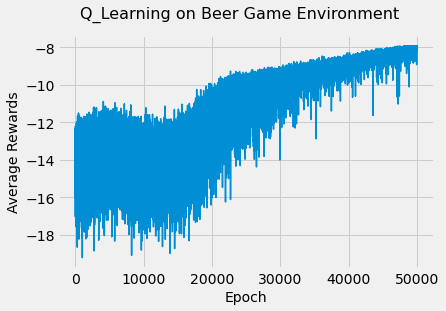

In [61]:
loop_treino(avg_customer_demand = 2, max_inventory = 5, max_order = 3, demand_random = False, num_episodes = 50000, agent_type = 'Q_Learning') 
# Eu recomendo diminuir o número de épocas para algo em torno de 1000 para os testes para rodar mais rápido e devolver para 100000 na entrega. 
# O treino costuma demorar em torno de 30 minutos

Resultado esperado:

- O gráfico plota a recompensa média de cada episódio ao longo do treino

- Há pequenas variações devido a aleatoriedade no estado inicial de cada época. 

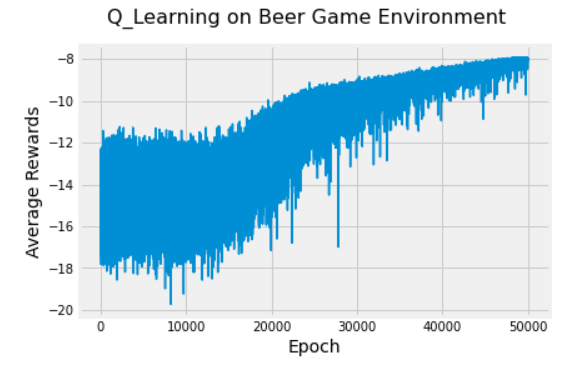

#### Teste para demanda do consumidor variável 

Episódio: 0
Episódio: 5000
Episódio: 10000
Episódio: 15000
Episódio: 20000
Episódio: 25000
Episódio: 30000
Episódio: 35000
Episódio: 40000
Episódio: 45000
Episódio: 50000
Episódio: 55000
Episódio: 60000
Episódio: 65000
Episódio: 70000
Episódio: 75000
Episódio: 80000
Episódio: 85000
Episódio: 90000
Episódio: 95000


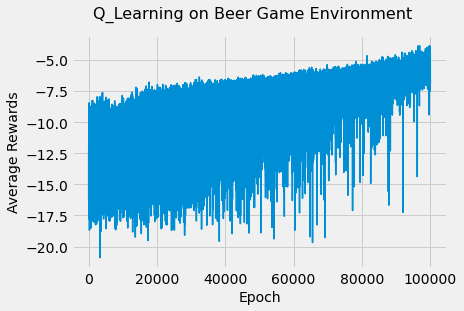

In [62]:
loop_treino(avg_customer_demand = 1, max_inventory = 4, max_order = 2, demand_random = True, num_episodes = 100000, agent_type = 'Q_Learning') 
# Eu recomendo diminuir o número de épocas para algo em torno de 1000 para os testes para rodar mais rápido e devolver para 100000 na entrega. 
# O treino costuma demorar em torno de 60 minutos

Resultado Esperado:

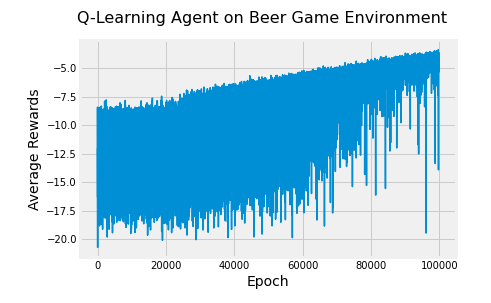

Observe que há um aumento da aleatoriedade nas recompensas/rewards justamente porque a demanda do cliente varia de acordo com a distribuição normal.

Repare também que foi necessário diminuir a complexidade do ambiente justamente para facilitar na convergência do sistema.

### Tarefa C) Agente Double Q-Learning

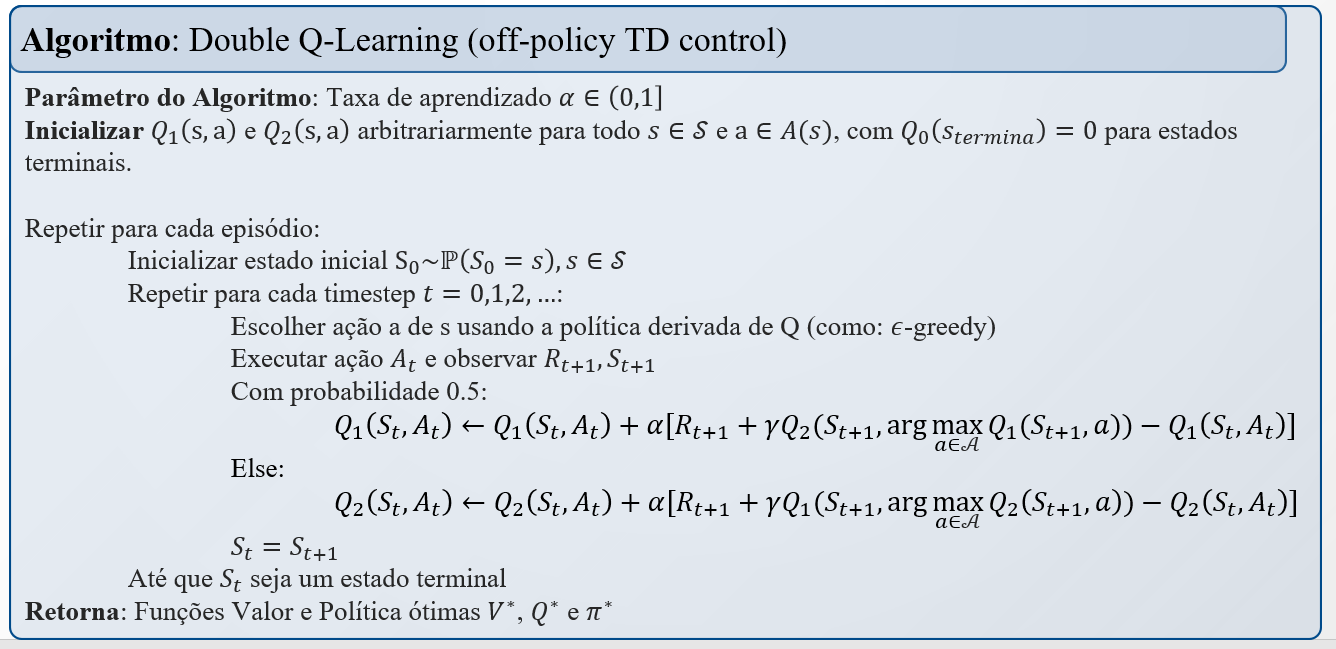

In [65]:

class Agent_Double_QLearning():
    def __init__(self, action_space, epsilon=0.99, alpha=0.6, gamma=0.3):

        # Looks like n is number of valid actions from the souce code
        self.valid_actions = action_space

        # Set parameters of the learning agent
        self.Q1 = dict()          # Q-table 
        self.Q2 = dict()          # Q-table 
        self.epsilon = epsilon   # Random exploration rate
        self.alpha = alpha       # Learning rate
        self.gamma = gamma       # Discount rate- closer to 1 learns well into distant future


    def create_Q_if_new_observation(self, observation):
        """
        Set intial Q values to 0.0 if observation not already in Q table
        """
        if observation not in self.Q1:
            self.Q1[observation] = dict((action, 0.0) for action in self.valid_actions)
            self.Q2[observation] = dict((action, 0.0) for action in self.valid_actions)
         
            
    def get_Q1argmaxQ2(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of
        all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        action = max(self.Q2[observation], key=self.Q2[observation].get)
        return self.Q1[observation][action]
    
    def get_Q2argmaxQ1(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of
        all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        action = max(self.Q1[observation], key=self.Q1[observation].get)
        return self.Q2[observation][action]

    #------------------------------------------------------------------------------
    # COMPLETAR
    #
    # choose_action(self, observation)
    #      Função que escolhe a ação seguindo a política epsilon-Greed
    #
    # INPUT:
    # observation
    #
    #
    # OUTPUT:
    # action
    #------------------------------------------------------------------------------
    def choose_action(self, observation):
        """
        Choose which action to take, based on the observation.
        If observation is seen for the first time, initialize its Q values to 0.0
        """
        self.create_Q_if_new_observation(observation)
        action = None
        # Pick the best action from Q1+Q2
        if random.random() > self.epsilon:
            maxQ1 = self.get_Q1argmaxQ2( observation )
            maxQ2 = self.get_Q2argmaxQ1( observation )
            if maxQ1 > maxQ2:
                for va in self.valid_actions:
                    if self.Q1[ observation ][ va ] == maxQ1:
                        action = va
                        break
            else:
                for va in self.valid_actions:
                    if self.Q2[ observation ][ va ] == maxQ2:
                        action = va
                        break
        # Performe a random action    
        else:
            ai = random.randint( 0, len(self.valid_actions) - 1 )
            action = self.valid_actions[ai]
        return action

    #------------------------------------------------------------------------------
    # COMPLETAR
    # learn(self, observation, action, reward, next_observation)
    #     Função que realiza o update da tabela Q
    #
    # INPUT:
    # observation
    # action
    # reward
    # next_observation
    #
    #
    # OUTPUT:
    #------------------------------------------------------------------------------
    def learn(self, observation, action, reward, next_observation):
        """
        Called after the agent completes an action and receives a reward.
        This function does not consider future rewards
        when conducting learning.
        """

        # Do the training for Q1
        if random.randint(1, 2) == 1:
            self.Q1[observation][action] = self.Q1[observation][action] + self.alpha * \
                ( reward + self.gamma * self.get_Q2argmaxQ1( next_observation ) - self.Q1[observation][action] )
        # Do the training for Q2
        else:
            self.Q2[observation][action] = self.Q2[observation][action] + self.alpha * \
                ( reward + self.gamma * self.get_Q1argmaxQ2( next_observation ) - self.Q2[observation][action] )

####Teste para demanda do consumidor constante 

Episódio: 0
Episódio: 5000
Episódio: 10000
Episódio: 15000
Episódio: 20000
Episódio: 25000
Episódio: 30000
Episódio: 35000
Episódio: 40000
Episódio: 45000


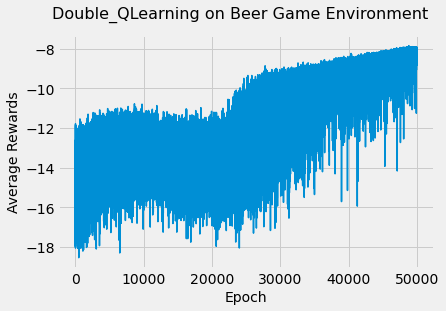

In [66]:
loop_treino(avg_customer_demand = 2, max_inventory = 5, max_order = 3, demand_random = False, num_episodes = 50000, agent_type = 'Double_QLearning') 
# Eu recomendo diminuir o número de épocas para algo em torno de 1000 para os testes para rodar mais rápido e devolver para 50000 na entrega. 
# O treino costuma demorar em torno de 30 minutos

Resultado Esperado

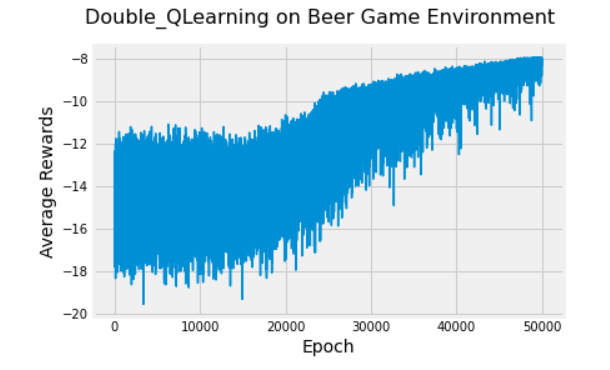

####Teste para demanda do consumidor variável 

Episódio: 0
Episódio: 5000
Episódio: 10000
Episódio: 15000
Episódio: 20000
Episódio: 25000
Episódio: 30000
Episódio: 35000
Episódio: 40000
Episódio: 45000
Episódio: 50000
Episódio: 55000
Episódio: 60000
Episódio: 65000
Episódio: 70000
Episódio: 75000
Episódio: 80000
Episódio: 85000
Episódio: 90000
Episódio: 95000


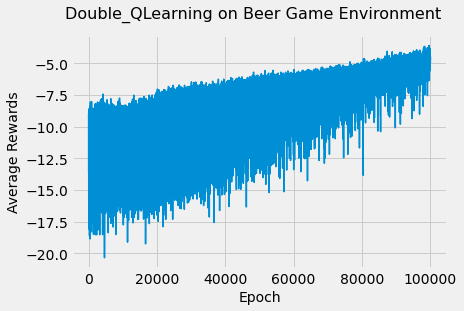

In [67]:
loop_treino(avg_customer_demand = 1, max_inventory = 4, max_order = 2, demand_random = True, num_episodes = 100000, agent_type = 'Double_QLearning') 
# Eu recomendo diminuir o número de épocas para algo em torno de 1000 para os testes para rodar mais rápido e devolver para 100000 na entrega. 
# O treino costuma demorar em torno de 60 minuto

Resultado Esperado

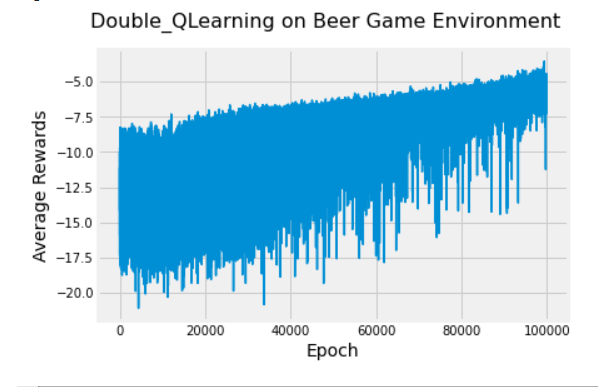